In [26]:
import pandas as pd
import os
import numpy as np
from IPython.display import display,display_html
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter("ignore")
os.chdir(r'X:\Priyabrata\NoSHOW\demand-forecasting-kernels-only')

In [2]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
#The training dataset contains 5 years of daily
#sales volumes of 50 items in 10 stores 
#(500 time series in total, from 2013 to 2017).

train = pd.read_csv('train.csv',parse_dates=['date'], index_col=[0])
test = pd.read_csv('test.csv',parse_dates=['date'], index_col=['date'])
train.sales = train.sales.astype(np.float)
#test.sales = test.sales.astype(np.float)
display_side_by_side(train.head(),test.head())

train = train[(train['store']==1)&(train['item']==1)]
test = test[(test['item']==1)&(test['store']==1)]
#The goal is to predict sales volumes of all items 
#in all stores in the first quarter of 2018. 
#The evaluation metric is SMAPE:average 2|yi−yi^|/(yi+yi^)⋅100%.
print('shape of train data ',train.shape)
print('shape of test data', test.shape)

,store,item,sales
date,,,
2013-01-01,1,1,13.0
2013-01-02,1,1,11.0
2013-01-03,1,1,14.0
2013-01-04,1,1,13.0
2013-01-05,1,1,10.0
,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1


shape of train data  (1826, 3)
shape of test data (90, 3)


In [4]:
#Data could be non-stationary
#Sales in stores could be correlated
#Data could have trend and seasonality
#Distribution may change based on time
display(pd.concat([train.isnull().sum().rename('Training NaNs'),
                   test.isnull().sum().rename('Test NaNs')], axis=1))

,Training NaNs,Test NaNs
id,NaN,0.0
item,0.0,0.0
sales,0.0,NaN
store,0.0,0.0


In [5]:
def create_features(df,sales=True):
    """
    Creates time series features from datetime index
    """
    df = df.reset_index()
    #print(df.head())
    #df.index = pd.to_datetime(df.index)
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    if sales:
        X = df[['date','sales','hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    else:
        X = df[['date','hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]  
    X = X.set_index('date')
    return X

In [6]:
train_n = create_features(train)
test_n = create_features(test,sales=False)
display_side_by_side(train_n.head(),test_n.head())

sales 
 hour 
 dayofweek 
 quarter 
 month 
 year 
 dayofyear 
 dayofmonth 
 weekofyear 
 
 
 date 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2013-01-01 
 13.0 
 0 
 1 
 1 
 1 
 2013 
 1 
 1 
 1 
 
 
 2013-01-02 
 11.0 
 0 
 2 
 1 
 1 
 2013 
 2 
 2 
 1 
 
 
 2013-01-03 
 14.0 
 0 
 3 
 1 
 1 
 2013 
 3 
 3 
 1 
 
 
 2013-01-04 
 13.0 
 0 
 4 
 1 
 1 
 2013 
 4 
 4 
 1 
 
 
 2013-01-05 
 10.0 
 0 
 5 
 1 
 1 
 2013 
 5 
 5 
 1 
 
 
 
 
 
 
 hour 
 dayofweek 
 quarter 
 month 
 year 
 dayofyear 
 dayofmonth 
 weekofyear 
 
 
 date 
 
 
 
 
 
 
 
 
 
 
 
 
 2018-01-01 
 0 
 0 
 1 
 1 
 2018 
 1 
 1 
 1 
 
 
 2018-01-02 
 0 
 1 
 1 
 1 
 2018 
 2 
 2 
 1 
 
 
 2018-01-03 
 0 
 2 
 1 
 1 
 2018 
 3 
 3 
 1 
 
 
 2018-01-04 
 0 
 3 
 1 
 1 
 2018 
 4 
 4 
 1 
 
 
 2018-01-05 
 0 
 4 
 1 
 1 
 2018 
 5 
 5 
 1

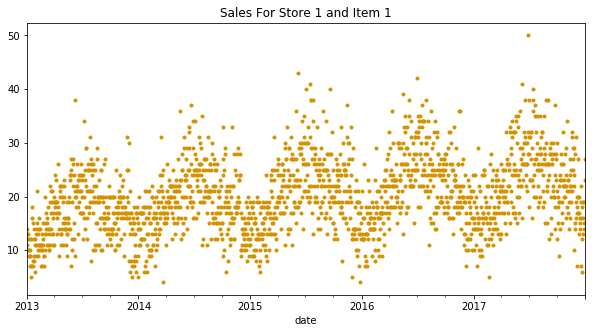

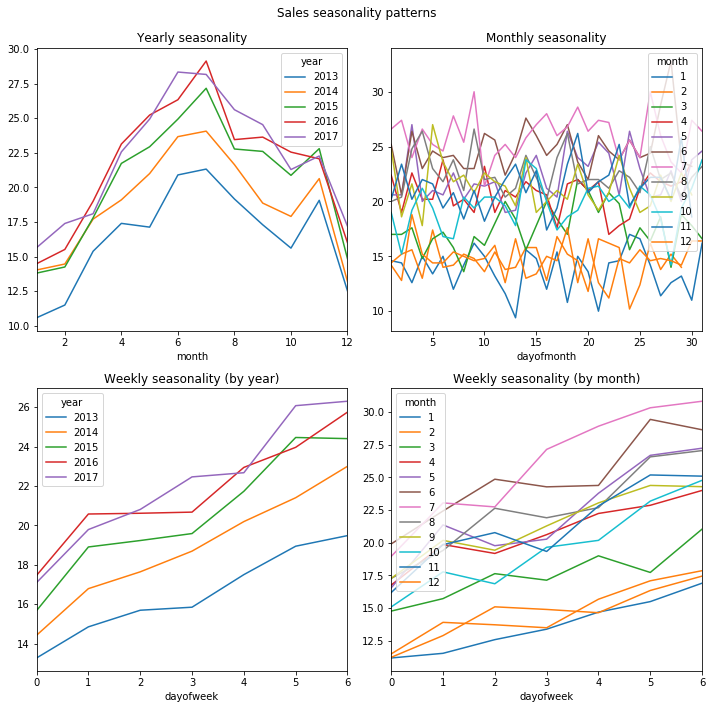

In [7]:
#Analysing seasonality pattern
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = train_n['sales'].plot(style='.', figsize=(10,5), color=color_pal[1], title='Sales For Store 1 and Item 1')
#train.groupby('date').mean()['sales'].plot(figsize=(10,3),title='Aggregated Sales');
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = pd.pivot_table(train_n, values='sales', columns='year', index='month').plot(title="Yearly seasonality", ax=ax[0,0])
_ = pd.pivot_table(train_n, values='sales', columns='month', index='dayofmonth').plot(title="Monthly seasonality", ax=ax[0,1])
_ = pd.pivot_table(train_n, values='sales', columns='year', index='dayofweek').plot(title="Weekly seasonality (by year)", ax=ax[1,0])
_ = pd.pivot_table(train_n, values='sales', columns='month', index='dayofweek').plot(title="Weekly seasonality (by month)", ax=ax[1,1])
fig.suptitle('Sales seasonality patterns')
fig.tight_layout(rect=[0, 0, 1, 0.96])

<Figure size 432x288 with 0 Axes>

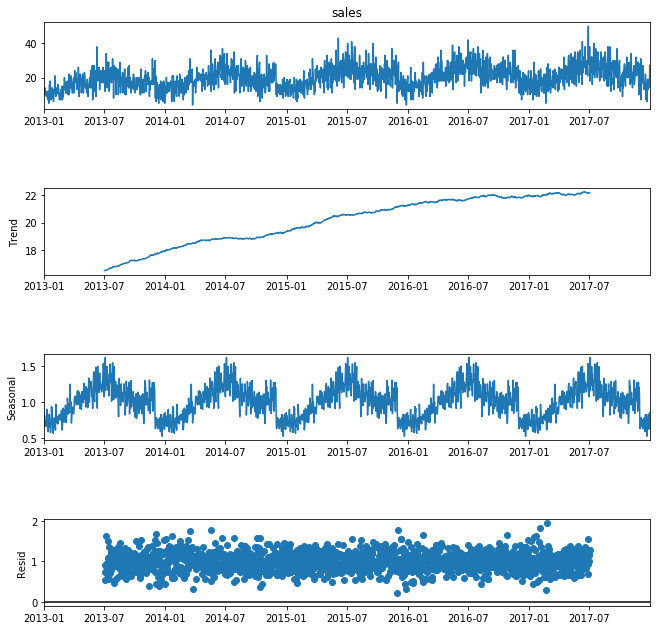

In [8]:
#Trend, Seasonality and Residual decomposition for sales in 1 store
from statsmodels.tsa.seasonal import seasonal_decompose
train_n['sales'] = train_n['sales'].astype(float)
result = seasonal_decompose(train_n['sales'], model='multiplicative', freq=365)

fig = plt.figure() ; 
fig = result.plot() ; 
fig.set_size_inches(10, 10);

In [9]:
#Non-stationarity Test and visualization
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data,column,window,cutoff=0.05):
    rolmean = data[column].rolling(window).mean()
    rolstd = data[column].rolling(window).std()
    
    #plotting statistics
    plt.figure(figsize=(12,8))
    original = plt.plot(data['sales'],color='red',label='Original data')
    rollingmean = plt.plot(rolmean,color='blue',label='Rolling Mean')
    rollingstd = plt.plot(rolstd,color ='green',label ='Rolling Std')
    plt.legend(loc='best')
    plt.title('Comparison between Rolling Mean & Std')
    plt.show()
    
    #Dickey Fuller Test
    df = adfuller(data[column],autolag='AIC',maxlag= 20)
    #dfmean = adfuller(rolmean,autolag='AIC',maxlag= 20)
    #dfstd = adfuller(rolstd,autolag='AIC',maxlag= 20)
    output=pd.Series(df[0:4],index=['Test Statistics',
                             'p-value',
                             'Lags used',
                             'Number of observations'])
    outputdf =pd.DataFrame(output)
    print(outputdf)
    #print('ADF test for original data ',df)
    #print('ADF test for Rolling Mean data ',dfmean)
    #print('ADF test for Rolling Std data ',dfstd)

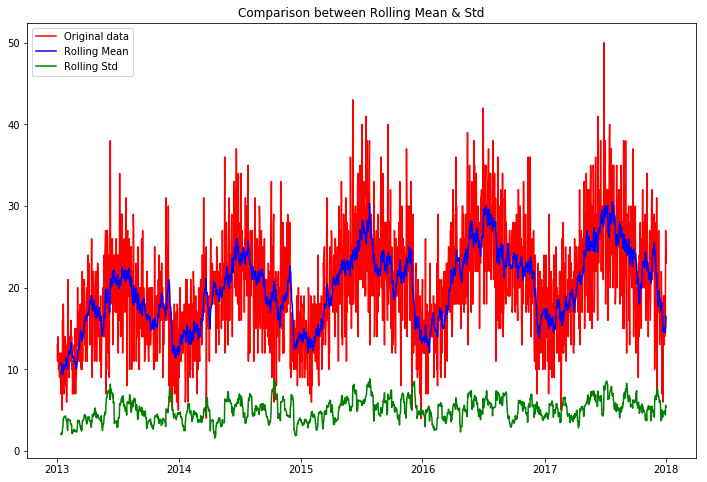

                                  0
Test Statistics           -2.987278
p-value                    0.036100
Lags used                 20.000000
Number of observations  1805.000000


In [10]:
test_stationarity(train_n,'sales',12,0.01)

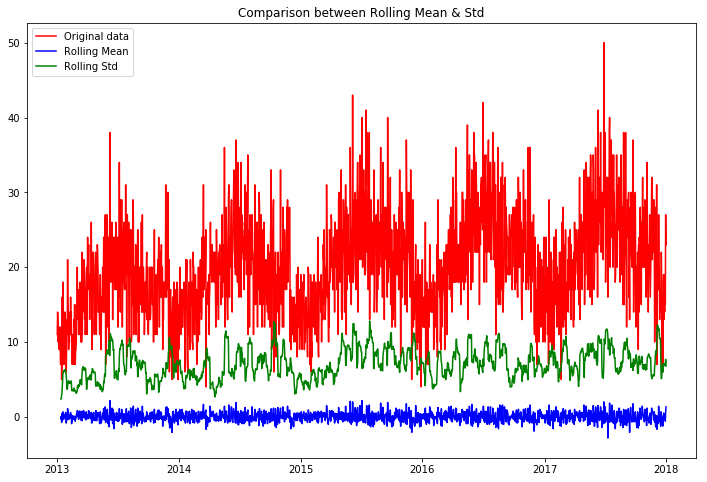

                                   0
Test Statistics        -1.520810e+01
p-value                 5.705031e-28
Lags used               2.000000e+01
Number of observations  1.804000e+03


In [11]:
#Stationarity test after 1st difference
train_n['firstdiff'] = train_n.sales-train_n.sales.shift(1)
train_n.dropna(inplace=True)
test_stationarity(train_n,'firstdiff',12,0.05)

In [12]:
#Intuition bethind ACF and PACF
#Present day sales could be due to past sales
#Similarly, future sales could be due to present day sales
#Sales at present are correlated to past sales
#ACF = Autocorrelation of sales at present and
#sales at different lags

#PACF: There are still some residuals 
#that carry correlation information with 
#previous sales. Both PACF and ACF 
#says how many factors to be taken
#into the model

from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#ACF Plot for stationary sales for store 1

def createACFandPACF(timeseries,lags=40):
    #print('ACF Values :', acf(store['firstdiff']),
          #' PACF Values :' ,pacf_ols(store['firstdiff'],nlags=20))

    plt.figure(figsize=(10,5));
    plt.title('ACF & PACF of stationary sales records')
    firstplot = lag_plot(timeseries);
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    _=plot_acf(timeseries,lags=lags,title = 'ACF Plot for 40 Lags',color='red',ax=ax[0])
    _=plot_pacf(timeseries, lags=lags,title = 'PACF Plot for 40 Lags',color='green',ax=ax[1])
    
    fig.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()
    

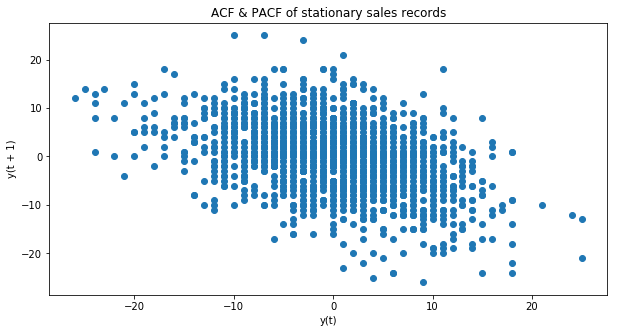

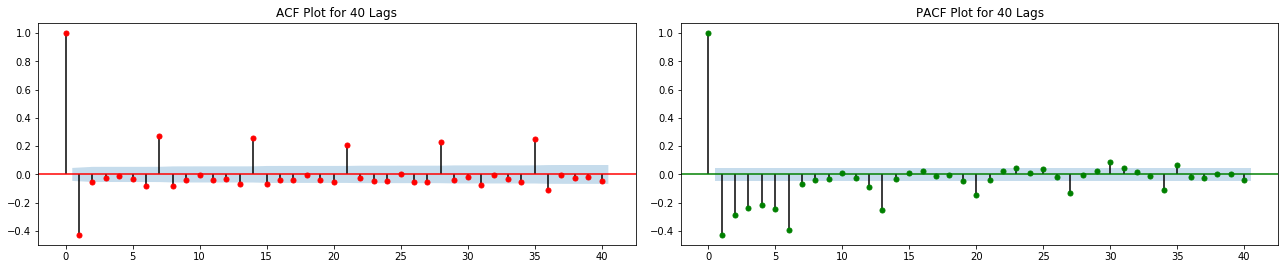

In [13]:
createACFandPACF(train_n['firstdiff'],lags=40)
#Since there are some weekly pattern 
#Seasonality should be taken into account
#SARIMA model will be build

In [37]:
train_n.shape
tr_start,tr_end = '2013-01-02','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
train_data = train_n[tr_start:tr_end].dropna()
test_data = train_n[te_start:te_end].dropna()
print(train_data.shape)
print(test_data.shape)

(1733, 10)
(92, 10)


**Selecting order using AIC criteria**

In [23]:
resDiff = sm.tsa.arma_order_select_ic(train_data.sales, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (7, 7) is the best.


### MODELING : ARIMA | SARIMA | ARIMAX | SARIMAX | XGBOOST | LSTM-RNN

**ARIMA MODEL**

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1733
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -5120.177
Date:                Wed, 11 Mar 2020   AIC                          10270.354
Time:                        11:50:43   BIC                          10352.140
Sample:                    01-02-2013   HQIC                         10300.610
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9215      0.030    -30.217      0.000      -0.981      -0.862
ar.L2         -0.9239      0.031    -30.193      0.000      -0.984      -0.864
ar.L3         -0.9265      0.030    -30.659      0.0

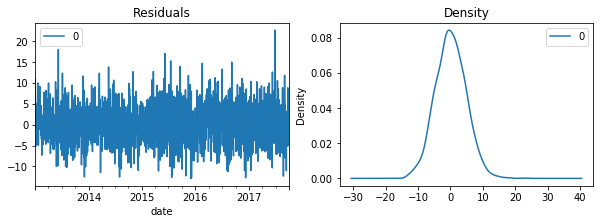

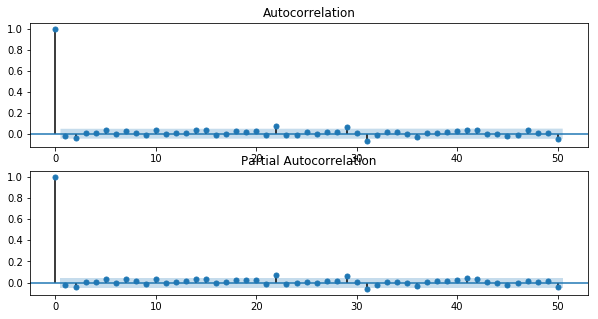

ARIMA model MSE:44.47784257534567


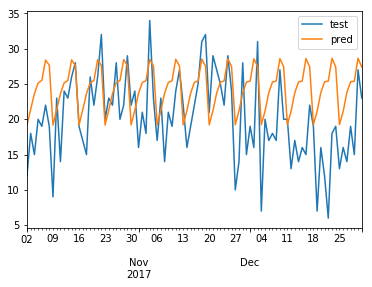

In [77]:
#ARIMA MODEL
import statsmodels.api as sm 
arima = sm.tsa.statespace.SARIMAX(train_data.sales,order=(7,1,7)
                                                  ,freq='D'
                                                  ,seasonal_order = (0,0,0,0)
                                                  ,enforce_stationarity = False
                                                  ,enforce_invertibility=False).fit(disp=False)
#AR1fit=model.fit(maxlag=1)
#AR2fit=model.fit(maxlag=2)
#print('AIC for lag1 :',AR1fit.aic)
#print('AIC for lag2 :',AR2fit.aic)
print(arima.summary())

# Plot residual errors
residuals = pd.DataFrame(arima.resid)
fig, ax = plt.subplots(1,2,figsize=(10,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
fig,ax = plt.subplots(2,1,figsize=(10,5))
fig = sm.graphics.tsa.plot_acf(residuals, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

pred = arima.predict(te_start,te_end)[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(test_data['sales']['2017-10-02':te_end],pred)))
pd.DataFrame({'test':test_data['sales']['2017-10-02':te_end],'pred':pred}).plot();plt.show()

**SARIMA MODEL**

10242.347870590966
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1733
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -5117.174
Date:                           Wed, 11 Mar 2020   AIC                          10242.348
Time:                                   11:46:07   BIC                          10264.160
Sample:                                        0   HQIC                         10250.417
                                          - 1733                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -7.17e-05      0.000     -0.419      0.675      -0.000       0.000
ma.L1         -0.8962   

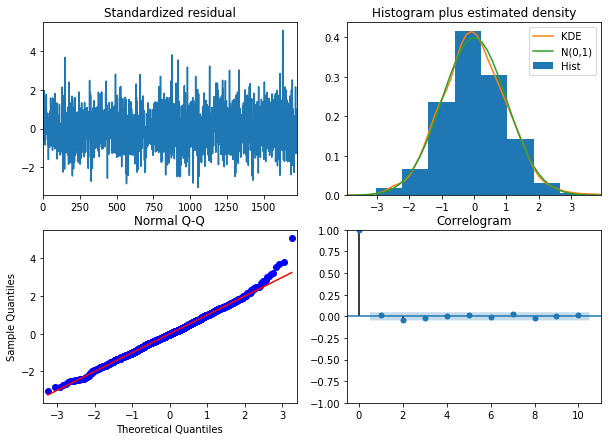

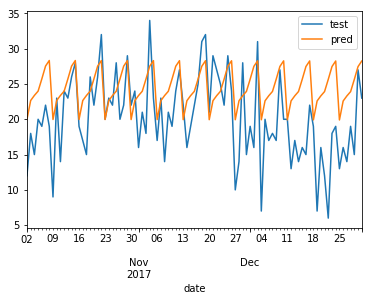

In [74]:
#SARIMA MODEL
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(train_data.sales.values, start_p=1, start_q=1,
                           max_p=7, max_q=7, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,maxiter =500)
print(stepwise_model.aic())
print(stepwise_model.summary())

stepwise_model.plot_diagnostics(figsize=(10,7));
pred = stepwise_model.predict(92)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_data['sales']['2017-10-02':te_end],pred)))
pd.DataFrame({'test':test_data['sales']['2017-10-02':te_end],'pred':pred}).plot();plt.show()

**XGBOOST MODEL**

In [63]:
#Creating multiple features for
#XGBOOST forecasting model
#store_df = create_features(store)
test_data.head()

,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,firstdiff
date,,,,,,,,,,
2017-10-01,21.0,0,6,4,10,2017,274,1,39,-9.0
2017-10-02,12.0,0,0,4,10,2017,275,2,40,-9.0
2017-10-03,18.0,0,1,4,10,2017,276,3,40,6.0
2017-10-04,15.0,0,2,4,10,2017,277,4,40,-3.0
2017-10-05,20.0,0,3,4,10,2017,278,5,40,5.0


[11:34:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBOOST model MSE:24.339544911260468


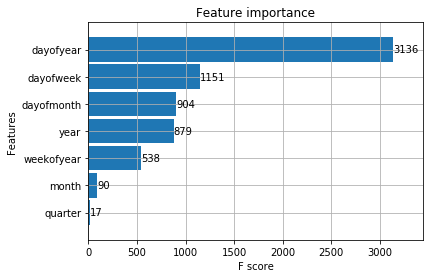

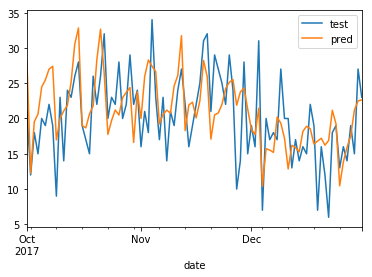

In [67]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
X = train_data.drop(['firstdiff','sales'],axis=1)
Y = train_data['sales']
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X,Y,verbose=False)
_ = plot_importance(reg, height=0.9)

pred = reg.predict(test_data.drop(['firstdiff','sales'],axis=1))
print('XGBOOST model MSE:{}'.format(mean_squared_error(test_data['sales'],pred)))
pd.DataFrame({'test':test_data['sales'],'pred':pred}).plot();plt.show()

**ARIMAX**

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1733
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -4007.324
Date:                Wed, 11 Mar 2020   AIC                           8062.649
Time:                        11:42:50   BIC                           8193.506
Sample:                    01-02-2013   HQIC                          8111.059
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour                0         -0        nan        nan           0           0
dayofweek      0.1791      0.047      3.807      0.000       0.087       0.271
quarter        1.4770      0.347      4.262      0.0

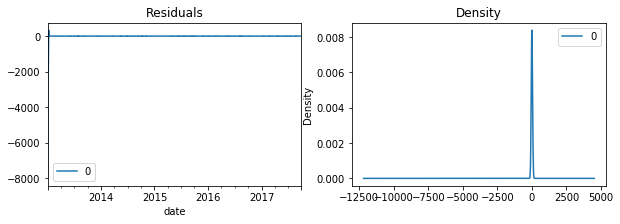

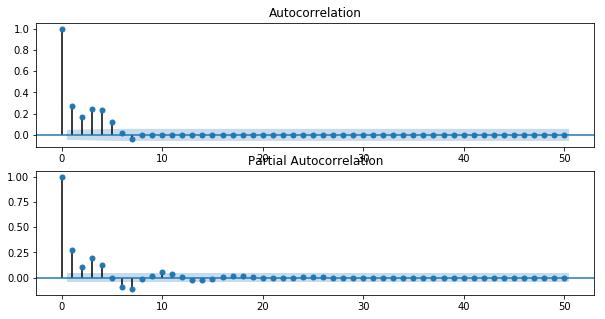

ARIMAX model MSE:48.00786530183907


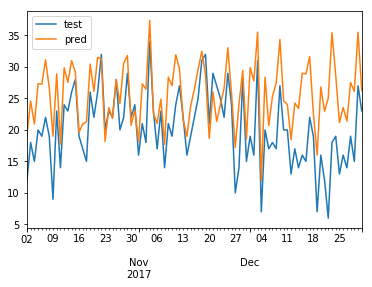

In [72]:
train_exog = train_data.drop(columns=['sales'])
test_exog = test_data.drop(columns=['sales'])
arimaX = sm.tsa.statespace.SARIMAX(train_data.sales,order=(7,1,7)
                                                  ,freq='D'
                                                  ,seasonal_order = (0,0,0,0)
                                                  ,enforce_stationarity = False
                                                  ,enforce_invertibility=False
                                                  ,exog=train_exog).fit(disp=False)

print(arimaX.summary())

# Plot residual errors
residuals = pd.DataFrame(arimaX.resid)
fig, ax = plt.subplots(1,2,figsize=(10,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
fig,ax = plt.subplots(2,1,figsize=(10,5))
fig = sm.graphics.tsa.plot_acf(residuals, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

pred = arimaX.predict(te_start,te_end,exog=test_exog)[1:]
print('ARIMAX model MSE:{}'.format(mean_squared_error(test_data['sales']['2017-10-02':te_end],pred)))
pd.DataFrame({'test':test_data['sales']['2017-10-02':te_end],'pred':pred}).plot();plt.show()

**SARIMAX MODEL**

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1733
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -4401.615
Date:                           Wed, 11 Mar 2020   AIC                           8827.231
Time:                                   11:52:40   BIC                           8892.604
Sample:                               01-02-2013   HQIC                          8851.421
                                    - 09-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour                0         -0        nan        nan           0           0
dayofweek  -6.614e-05      0.023     -0.003

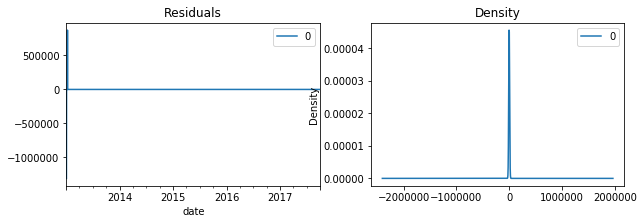

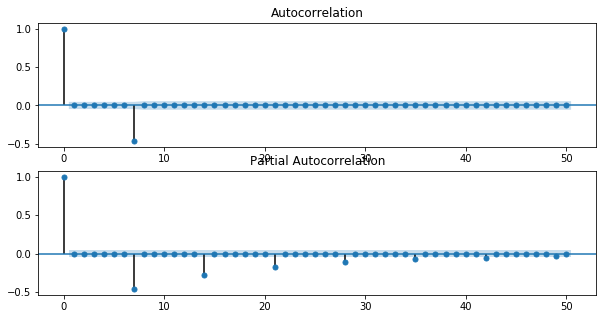

SARIMAX model MSE:76.29027704355053


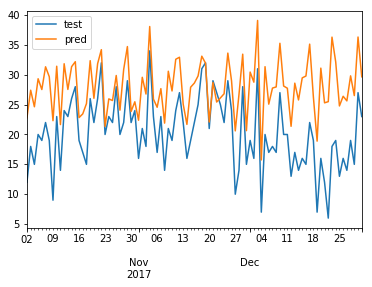

In [78]:
from pmdarima.arima import auto_arima
sarimaX = sm.tsa.statespace.SARIMAX(train_data.sales,order=(0,1,1)
                                                  ,freq='D'
                                                  ,seasonal_order = (0, 1, 1, 7)
                                                  ,enforce_stationarity = False
                                                  ,enforce_invertibility=False
                                                  ,exog=train_exog).fit(disp=False)
print(sarimaX.summary())

# Plot residual errors
residuals = pd.DataFrame(sarimaX.resid)
fig, ax = plt.subplots(1,2,figsize=(10,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
fig,ax = plt.subplots(2,1,figsize=(10,5))
fig = sm.graphics.tsa.plot_acf(residuals, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

pred = sarimaX.predict(te_start,te_end,exog=test_exog)[1:]
print('SARIMAX model MSE:{}'.format(mean_squared_error(test_data['sales']['2017-10-02':te_end],pred)))
pd.DataFrame({'test':test_data['sales']['2017-10-02':te_end],'pred':pred}).plot();plt.show()

**LSTM MODEL**

In [84]:
#We need to use previous monthly sales data to 
#forecast the next ones. The look-back period may 
#vary for every model. Ours will be 12 for this example
for i in range(1,13):
    field_name='lag_'+str(i)
    train_data[field_name]=train_data['firstdiff'].shift(i)
    test_data[field_name]=test_data['firstdiff'].shift(i)

In [85]:
#drop null values
train_data = train_data.dropna()
test_data = test_data.dropna()
display_side_by_side(train_data.head(),test_data.head())

,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,firstdiff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
date,,,,,,,,,,,,,,,,,,,,,,
2013-02-07,13.0,0,3,1,2,2013,38,7,6,3.0,1.0,-5.0,-1.0,-6.0,10.0,-2.0,4.0,3.0,-5.0,-1.0,0.0,-2.0
2013-02-08,11.0,0,4,1,2,2013,39,8,6,-2.0,3.0,1.0,-5.0,-1.0,-6.0,10.0,-2.0,4.0,3.0,-5.0,-1.0,0.0
2013-02-09,14.0,0,5,1,2,2013,40,9,6,3.0,-2.0,3.0,1.0,-5.0,-1.0,-6.0,10.0,-2.0,4.0,3.0,-5.0,-1.0
2013-02-10,11.0,0,6,1,2,2013,41,10,6,-3.0,3.0,-2.0,3.0,1.0,-5.0,-1.0,-6.0,10.0,-2.0,4.0,3.0,-5.0
2013-02-11,16.0,0,0,1,2,2013,42,11,7,5.0,-3.0,3.0,-2.0,3.0,1.0,-5.0,-1.0,-6.0,10.0,-2.0,4.0,3.0
,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,firstdiff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
date,,,,,,,,,,,,,,,,,,,,,,
2017-10-25,22.0,0,2,4,10,2017,298,25,43,-1.0,3.0,-12.0,6.0,4.0,-4.0,11.0,-2.0,-2.0,-9.0,2.0,3.0,-1.0
2017-10-26,28.0,0,3,4,10,2017,299,26,43,6.0,-1.0,3.0,-12.0,6.0,4.0,-4.0,11.0,-2.0,-2.0,-9.0,2.0,3.0


In [110]:
#LSTM with pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [90]:
def c(X,x_train):
    X = X-np.mean(x_train,axis=0)
    X_standard = X/np.std(x_train,axis=0)
    return X_standard

In [226]:
tr_start,tr_end = '2013-01-02','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
train_lstm = train_data[tr_start:tr_end].dropna()
test_lstm = train_data[te_start:te_end].dropna()

In [227]:
#Creating tensor values for X and Y
x_train = train_lstm.drop(columns=['firstdiff','sales'])
x_test = test_lstm.drop(columns=['firstdiff','sales'])
y_train = train_lstm['firstdiff'].values
y_test = test_lstm['firstdiff'].values

X_train_std = standardization(x_train,x_train)
X_test_std = standardization(x_test,x_train)
print('Mean of standardized train data',
      "\n",X_train_std.mean(),
      "\n",'Std of standardized train data',
      "\n",X_train_std.std(),
      "\n",'Mean of standardized test data',
      "\n",X_test_std.mean(),
      "\n",'Std of standardized test data',
      "\n",X_test_std.std())

Mean of standardized train data 
 hour                   NaN
dayofweek    -7.091819e-17
quarter      -1.647998e-16
month        -1.812208e-16
year         -1.899535e-14
dayofyear    -7.346968e-17
dayofmonth    7.523609e-17
weekofyear    8.361020e-17
lag_1         1.282285e-17
lag_2         2.204745e-17
lag_3        -1.321538e-17
lag_4        -2.767380e-17
lag_5         1.805666e-17
lag_6        -1.439299e-18
lag_7        -1.831835e-17
lag_8        -1.910343e-17
lag_9         2.800724e-17
lag_10        1.426215e-17
lag_11        2.265261e-17
lag_12        6.149733e-18
dtype: float64 
 Std of standardized train data 
 hour               NaN
dayofweek     1.000295
quarter       1.000295
month         1.000295
year          1.000295
dayofyear     1.000295
dayofmonth    1.000295
weekofyear    1.000295
lag_1         1.000295
lag_2         1.000295
lag_3         1.000295
lag_4         1.000295
lag_5         1.000295
lag_6         1.000295
lag_7         1.000295
lag_8         1.000295
lag_9   

In [228]:
# Dropping NAN columns 
X_train_std=X_train_std.dropna(axis=1)
X_test_std = X_test_std.dropna(axis=1)

In [229]:
# The next step is to convert our dataset
#into tensors since PyTorch models
#are trained using tensors
x_train_t = Variable(torch.FloatTensor(X_train_std.values).view(-1))
x_test_t = Variable(torch.tensor(X_test_std.values))
y_train_t = Variable(torch.tensor(y_train))
y_test_t = Variable(torch.tensor(y_test))

In [258]:
print((X_train_std.shape))
print((y_train[34,]))


(1697, 19)
-1.0


In [278]:
#The final preprocessing step is to convert
#our training data into sequences and corresponding labels
#We had daily data, a better sequence length would be 365
def sliding_windows(X,Y, seq_length):
    #x = []
    #y = []
    inout_seq=[]
    for i in range(len(X)-seq_length-1):
        _x = X[i:(i+seq_length)].values
        _y = Y[i+seq_length,]
        inout_seq.append((_x,_y))
        #y.append(_y)
    #return np.array(x),np.array(y)
    return inout_seq

In [282]:
train_seq= sliding_windows(X_train_std,y_train,30)
test_seq = sliding_windows(X_test_std,y_test,30)
#print(train_seq[:1])

In [270]:
class LSTM(nn.Module):

    def __init__(self, input_size=19, hidden_layer_size=50, output_size=1):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.LSTM(input_size,hidden_layer_size,batch_first=True)
        self.fc =nn.Linear(hidden_layer_size,output_size)
        
    def forward(self,t):
        t=t
        
        #Hidden LSTM Layer
        lstm_out, self.hidden_cell=self.rnn(t.view(30,1,-1),50,1)
        predictions = self.fc(lstm_out.view(30,-1))
        return predictions[-1]

In [271]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (rnn): LSTM(19, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [283]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

TypeError: view() takes at most 2 arguments (3 given)